In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Computer_Vision_Project')

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4709407487696022658
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12022357851302387457
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-3da47e2b-3c4d-8add-5bad-5a6df256c7c1)


# Imports

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras
import cv2
from tensorflow.python.keras.models import Model
from IPython.display import display as display_fn
from IPython.display import Image, clear_output
from google.colab import files
# The following is a substitute for cv2.imshow, which Colab does not allow
from google.colab.patches import cv2_imshow

# Image Functions

## Loading Images

Loading Image as an tensor

In [ ]:
# method to load the given image path into python
def read_in(path, scale_img=True, plot=False):

  # read image with opencv in color
  cv2_image = cv2.imread(path, 1) # 1 denotes the image will be read in color

  # conditional statement to check if the user wants to scale the image
  if (scale_img):

    # scale the image
    cv2_image = scale(cv2_image)

  # conditional statement to check if the user wants to plot the image
  if (plot):

    # plot the image
    cv2_imshow(cv2_image)

  # otherwise, return the original image
  return cv2_image


# method to scale the given image by the largest dimensions
def scale(im):

  # find the largest dimension
  largest_side = np.max(im.shape)

  # compute the scale factor that will be used to reshape the image
  scale = 512 / largest_side

  # reshape the image by the scale
  reshaped_im = cv2.resize(im, dsize = (0, 0), fx = scale, fy = scale)

  # return the image
  return reshaped_im


# method to convert opencv images to tensorflow images
def cv_to_tf(cv_im):
  
  # tensorflow stores images in RGB format whereas openCV stores as BGR
  # the following lines of code map a tensor from BGR to RGB
  cv_im = cv2.cvtColor(cv_im, cv2.COLOR_BGR2RGB)
  cv_im.shape = (1, cv_im.shape[0], cv_im.shape[1], cv_im.shape[2])
  cv_im = tf.convert_to_tensor(cv_im)

  # return the image
  return cv_im

In [ ]:
def load_images(content_image_path, style_image_path):
  c_img = read_in("{}".format(content_image_path))
  s_img = read_in("{}".format(style_image_path))
  return c_img, s_img

## Displaying Images

In [ ]:
def display_image(image):
  if len(image.shape) == 4:
    img = np.squeeze(image, axis = 0)
  img = deprocess(img)
  plt.figure(figsize=(10, 12))
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)
  return

## Preprocessing Image

In [ ]:
def preprocess_image(image):
  image = tf.cast(image, dtype=tf.float32)
  image = tf.keras.applications.vgg19.preprocess_input(image)
  return image

## Deprocessing Image

In [ ]:
def deprocess(tensor):
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor) 

## Loading and Viewing Images from Directory

In [ ]:
content_image_path = os.path.join(os.getcwd(),r'Content_Images/content14.jpeg')
style_image_path = os.path.join(os.getcwd(), r'Style_Images/style2.jpeg')

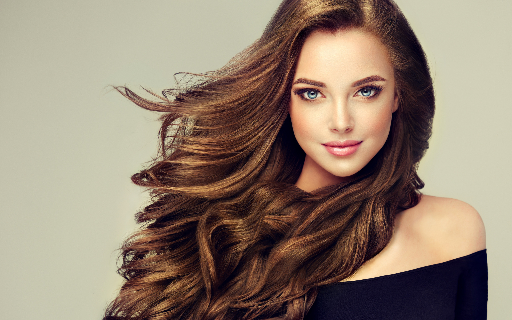

In [ ]:
# plot content image
content_image = read_in(content_image_path, plot=True)

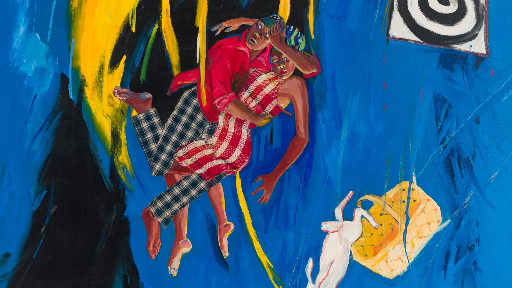

In [ ]:
# plot style image
style_image = read_in(style_image_path, plot=True)

# Loading VGG19 Model

In [ ]:
keras.backend.clear_session()

In [ ]:
vgg = tf.keras.applications.vgg19.VGG19(include_top = False, weights = 'imagenet')
vgg.trainable = False
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

# VGG19 as Feature Extractor

The shallower layers of a ConvNet tend to detect lower-level features such as edges and simple textures while the deeper layers tend to detect higher-level features such as more complex textures and object classes. Exploiting this, we will use starting layers of different/all convolution blocks of VGG19 to obtain style of the image, while we will use the second layer of the last convolution block to obtain content features from content image.

## Content Feature Extractor

In [ ]:
def content_model(layers):
  c_model = Model(inputs = vgg.input, outputs = [vgg.get_layer(layer).output for layer in layers])
  return c_model

C_LAYER_LIST = ['block4_conv2', 'block5_conv2', 'block5_conv3' ]
c_layers = [C_LAYER_LIST[1]]

c_extractor = content_model(c_layers)

## Style Feature Extractor

In [ ]:
def style_model(layers):
  s_models = Model(inputs = vgg.input, outputs = [vgg.get_layer(layer).output for layer in layers])
  return s_models

S_LAYER_LIST = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1','block5_conv1'] 
s_layers = S_LAYER_LIST[:]

s_extractor = style_model(s_layers)

# Loss

Total loss will be calculated by combining content loss and style loss.

## a) Content Loss

It is the the sum of the squared error between the content features of content image and generated image and multiplied by a scaling factor(0.5).

### Getting Content Features

In [ ]:
def content_features(img):
  preprocessed = preprocess_image(img)
  content_extractions = c_extractor(preprocessed)
  return content_extractions

### Calculating Content Loss

In [ ]:
def content_loss(generated, content):
  loss = 0.5 * tf.reduce_sum(tf.square(generated - content)) 
  return loss

## b) Style loss

The style loss is the average of the squared differences between the style representations of style image and generated image.

The style is represented in the form of Gram Matrix.

### Gram Matrix

In [ ]:
def gram_matrix(A):
  channels = int(A.shape[-1])
  a = tf.reshape(A, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a = True)
  return gram / tf.cast(n, tf.float32)

### Getting Style Features

In [ ]:
def style_features(img): 
  preprocessed = preprocess_image(img)
  style_extractions = s_extractor(preprocessed)
  gram_representation = [gram_matrix(layer) for layer in style_extractions] 
  return gram_representation

###Calculating Style Loss

In [ ]:
def style_loss(generated, style):
  loss = tf.reduce_mean(tf.square(generated - style))  
  return loss

## Total Loss

The total loss is given by $L_{total} = \alpha L_{content} + \beta L_{style}$, where $\alpha$ and $\beta$ are weights we will give to the content and style features to generate the new image.

In [ ]:
def total_loss(gen_c_features, orig_c_features, gen_s_features, orig_s_features, alpha, beta):
  
  j_c = tf.add_n([content_loss(gen, orig) for gen, orig in zip(gen_c_features, orig_c_features)])
  j_c = j_c * alpha / len(c_layers)

  j_s = tf.add_n([style_loss(gen, orig) for gen, orig in zip(gen_s_features, orig_s_features)])
  j_s = j_s * beta / len(s_layers)

  J = j_c + j_s
  return J

# Generating Stylized Image by calculating gradient and updating generated image

## Gradient Calculation

In [ ]:
def gradient(gen_image, orig_c_features, orig_s_features, alpha, beta, var_weight):
  
  with tf.GradientTape() as g:
    gen_s_features = style_features(gen_image) 
    gen_c_features = content_features(gen_image) 
      
    J = total_loss(gen_c_features, orig_c_features, gen_s_features, orig_s_features, alpha, beta) 
    J += var_weight * tf.image.total_variation(gen_image)

  grad = g.gradient(J, gen_image) 
  return grad

### Updating Generated Image

In [ ]:
def update_generated(gen_image, orig_c_features, orig_s_features, alpha, beta, var_weight, optimizer):
                          
  gradients = gradient(gen_image, orig_c_features, orig_s_features, alpha, beta, var_weight) 

  optimizer.apply_gradients([(gradients, gen_image)]) 

  gen_image.assign(tf.clip_by_value(gen_image, clip_value_min = 0.0, clip_value_max = 255.0))

# Style Transfer

In [ ]:
def style_transfer(content_image, style_image, alpha, beta, var_weight,optimizer, iterations):

  content_image = cv_to_tf(content_image)
  style_image = cv_to_tf(style_image)

  orig_c_features = content_features(content_image)
  orig_s_features = style_features(style_image)
  
  generated_image = tf.cast(content_image, dtype=tf.float32)
  generated_image = tf.Variable(generated_image)
  
  print('Stylized Image Generation Iterative Process Started')
  for n in range(iterations):
    update_generated(generated_image, orig_c_features, orig_s_features, alpha, beta, var_weight, optimizer)
    if (n + 1) % 100 == 0:
      clear_output(wait=True)
      print('{} iterations completed'.format(n+1))
      print('Output Image After Iteration: {}'.format(n+1))
      display_image = deprocess(generated_image)
      display_fn(display_image)

  generated_image = tf.cast(generated_image, dtype=tf.uint8)
  return generated_image

1000 iterations completed
Output Image After Iteration: 1000


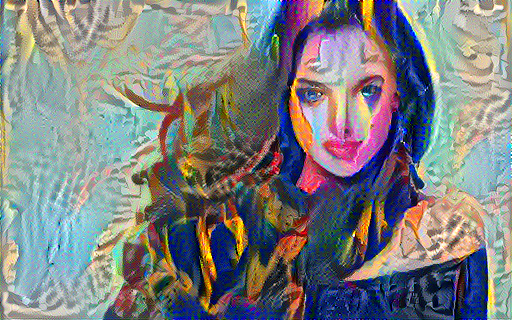

In [ ]:
content_weight_list = [1, 2, 10]
style_weight_list = [1, 2, 10, 100, 1000, 10000]

alpha = content_weight_list[0]
beta = style_weight_list[2]

var_weight = 2

adam = tf.optimizers.Adam(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 20.0, decay_steps = 100, decay_rate = 0.50))

iterations_list = [500, 1000, 1500, 2000]
iterations = iterations_list[1]

art_image = style_transfer(content_image = content_image, style_image = style_image, alpha = alpha, 
                           beta = beta, var_weight = var_weight, optimizer = adam , iterations = iterations)

In [ ]:
file_name = 'style.png'
deprocess(art_image).save(file_name)
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

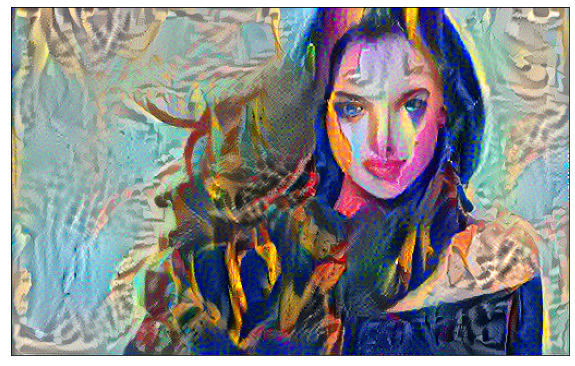

In [ ]:
display_image(art_image)